In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.parametrizations import orthogonal
from torch.nn import functional as F
from IPython.display import clear_output
from io import BytesIO
try:
    from pandas.io.common import ZipFile
except ImportError:
    from zipfile import ZipFile

from tqdm.notebook import tqdm

from dataprep import transform_indices, full_preproccessing
from utils import topn_recommendations, downvote_seen_items, make_prediction

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# def dcg(tensor: torch.Tensor) -> torch.Tensor:
#     gains = (2**tensor) - 1
#     return gains / torch.log2(torch.arange(0, tensor.size(-1), dtype=torch.float, device=tensor.device) + 2.0)


# def ndcg(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
#     # output, target ~ (users, items)
#     # target_sorted_by_output ~ (users, items)
#     target_sorted_by_output = prepare_target(output, target)
#     ideal_target = prepare_target(target, target)
#     # YOUR CODE HERE
#     topk = min(topk, output.shape[-1])
#     ndcg = dcg(target_sorted_by_output[:, :topk]).sum(dim=1)
#     idcg = dcg(ideal_target[:, :topk]).sum(dim=1)
#     ndcg[idcg > 0] = ndcg[idcg > 0] / idcg[idcg > 0]
    
#     return ndcg.mean(dim=0)

In [4]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
fix_torch_seed(42)
set_random_seed(42)

In [38]:
# answer = binary matrix (no ratings)
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)
        
        self.augment = augment

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0,10)
            idxs = torch.randint(0, self.tensor.shape[0], size=num_noise)
            noised_input = self.tensor[idx].detach().clone()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,))
            return noised_input, self.matrix[idx]
        else:
            return self.tensor[idx], self.matrix[idx]

## Preprocess data

In [15]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [16]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cuda', index=0)

## Model: triangular matrix

In [19]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [20]:
len(train_dataloader)

823

In [21]:
data_description['n_items'], data_description['n_ratings']

(9906, 5)

In [52]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            m.weight.copy_(torch.tril(m.weight))
            
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [53]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = self.relu(output)
        output = torch.matmul(output, self.L.weight)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.matmul(outputT, self.V.weight)
        output = torch.transpose(outputT, -1, -2)
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [54]:
fix_torch_seed(42)
set_random_seed(42)

ae = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [55]:
ae.L.weight# @ ae.L.weight

Parameter containing:
tensor([[-0.1739,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1754,  0.6074,  0.0000,  0.0000,  0.0000],
        [ 0.5197,  0.3342, -0.5307,  0.0000,  0.0000],
        [ 0.2015,  0.0073, -0.5652,  0.0950,  0.0000],
        [-0.3428,  0.7385,  0.1949,  0.5154, -0.5906]], device='cuda:0',
       requires_grad=True)

In [56]:
mask = torch.triu(torch.ones_like(ae.L.weight)).T
# Register with hook
ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [57]:
sum(p.numel() for p in ae.parameters() if p.requires_grad)

2536251

Epoch 20


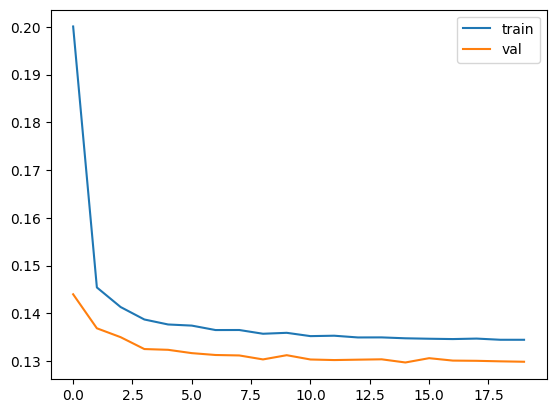

In [35]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

In [58]:
ae.L.weight

Parameter containing:
tensor([[-0.1739,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1754,  0.6074,  0.0000,  0.0000,  0.0000],
        [ 0.5197,  0.3342, -0.5307,  0.0000,  0.0000],
        [ 0.2015,  0.0073, -0.5652,  0.0950,  0.0000],
        [-0.3428,  0.7385,  0.1949,  0.5154, -0.5906]], device='cuda:0',
       requires_grad=True)

In [59]:
ae.L.weight @ ae.L.weight.T

tensor([[ 0.0302, -0.0305, -0.0904, -0.0350,  0.0596],
        [-0.0305,  0.3997,  0.2941,  0.0398,  0.3884],
        [-0.0904,  0.2941,  0.6634,  0.4070, -0.0348],
        [-0.0350,  0.0398,  0.4070,  0.3691, -0.1249],
        [ 0.0596,  0.3884, -0.0348, -0.1249,  1.3154]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [38]:
# Testing the AE
test_loss = 0
# model = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
# model.load_state_dict(torch.load('best-model.pt'))

scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False
    scores[i] = output[0].T

    loss = criterion(output, target)
    test_loss += loss.data.item()

scores = scores.detach().numpy()    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.12897759667405873


In [40]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0092, MRR@5 = 0.0058, Coverage@5 = 0.0203
HR_pos@5 = 0.0081, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0054, MRR_neg@5 = 0.0004
Matthews@5 = 0.0137
-------------------------------------
HR@10 = 0.0190, MRR@10 = 0.0070, Coverage@10 = 0.0317
HR_pos@10 = 0.0178, HR_neg@10 = 0.0012
MRR_pos@10 = 0.0066, MRR_neg@10 = 0.0004
Matthews@10 = 0.0431
-------------------------------------
HR@20 = 0.0409, MRR@20 = 0.0085, Coverage@20 = 0.0529
HR_pos@20 = 0.0380, HR_neg@20 = 0.0029
MRR_pos@20 = 0.0080, MRR_neg@20 = 0.0005
Matthews@20 = 0.0587
-------------------------------------


(0.007043536632144227, 0.0189873417721519, 0.04310505000932261)

### Tuning

In [14]:
grid1 = 2**np.arange(9, 11) #2**np.arange(4, 11)
grid2 = np.arange(3, 5)
grid = np.meshgrid(grid2, grid1)

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []
early_stop = 10
n_epochs = 1000


for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=14):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    mask = torch.triu(torch.ones_like(ae.L.weight)).T
#     Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []
#     prev_train_loss = []
    prev_test_loss = [1000]
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1
    
    for epoch in range(n_epochs):
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / len(train_dataloader))

        test_loss = 0
        with torch.no_grad():
            for user in testset_valid.userid.unique():
                itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
                feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
                values = np.ones(len(itemidx), dtype=np.float32)

                user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
                target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

                output = ae(user_tensor_test)
                target.require_grad = False

                loss = criterion(output, target)
                test_loss += loss.data.item()
        val_loss = test_loss / testset.userid.nunique()
        val_history.append(val_loss)

        if prev_test_loss[-1] > val_loss:
            prev_test_loss = [val_loss]
            torch.save(bae.state_dict(), f'best_ae_{h}.pt')
        else:
            prev_test_loss.append(val_loss)
        
        stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_test_loss) == early_stop:
            print(f'Current epoch {epoch}. Best model found at epoch {stop}')
            break
            
        epoch += 1
    
    # Testing the AE
    test_loss = 0
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    model = AE(data_description['n_items'], h).to(device)
    model.load_state_dict(torch.load(f'best_ae_{h}.pt'))

    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        scores[i] = output[0].T
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())        
    scores = scores.detach().numpy()
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    print('Epochs:', stop)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

## Model: triangular banded matrix

In [78]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [79]:
len(train_dataloader)

823

In [80]:
data_description['n_items'], data_description['n_ratings']

(9906, 5)

In [274]:
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [276]:
class bandedLinear(nn.Module):
    def __init__(self, num_features, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.device = device
        super().__init__()
        self.num_features = num_features
        self.weight = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty(num_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        M = torch.zeros((self.num_features, self.num_features), device=self.weight.device)
        for i in range(self.num_features):
            d = torch.ones(self.num_features-i, device=self.weight.device) * self.weight[i]
            M = M + torch.diag(d, diagonal=-i)
        return F.linear(input, M, self.bias)

    def extra_repr(self):
        return 'num_features={}, bias={}'.format(
            self.num_features, self.bias is not None
        )

In [277]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = bandedLinear(n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
#         x = self.norm(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = self.relu(output)
        
        M = torch.zeros((self.L.weight.shape[0], self.L.weight.shape[0]), device=self.L.weight.device)
        for i in range(self.L.weight.shape[0]):
            d = torch.ones(self.L.weight.shape[0]-i, device=self.L.weight.device) * self.L.weight[i]
            M = M + torch.diag(d, diagonal=-i)
            
        output = torch.matmul(output, M)
#         output = self.norm(output)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.matmul(outputT, self.V.weight)
        output = torch.transpose(outputT, -1, -2)
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [278]:
fix_torch_seed(42)
set_random_seed(42)

ae = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [279]:
M = torch.zeros((data_description['n_ratings'], data_description['n_ratings']), device=ae.L.weight.device)
for i in range(data_description['n_ratings']):
    d = torch.ones(data_description['n_ratings']-i, device=ae.L.weight.device) * ae.L.weight[i]
    M = M + torch.diag(d, diagonal=-i)
M

tensor([[-0.8092,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3950, -0.8092,  0.0000,  0.0000,  0.0000],
        [-0.4151,  0.3950, -0.8092,  0.0000,  0.0000],
        [-0.3274, -0.4151,  0.3950, -0.8092,  0.0000],
        [-0.4320, -0.3274, -0.4151,  0.3950, -0.8092]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [280]:
M @ M.T

tensor([[ 0.6548, -0.3196,  0.3359,  0.2650,  0.3496],
        [-0.3196,  0.8108, -0.4835,  0.2066,  0.0943],
        [ 0.3359, -0.4835,  0.9831, -0.3476,  0.3859],
        [ 0.2650,  0.2066, -0.3476,  1.0903, -0.2062],
        [ 0.3496,  0.0943,  0.3859, -0.2062,  1.2769]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [266]:
# mask = torch.triu(torch.ones_like(ae.L.weight))
# # Register with hook
# ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [281]:
sum(p.numel() for p in ae.parameters() if p.requires_grad)

2536231

Epoch 3


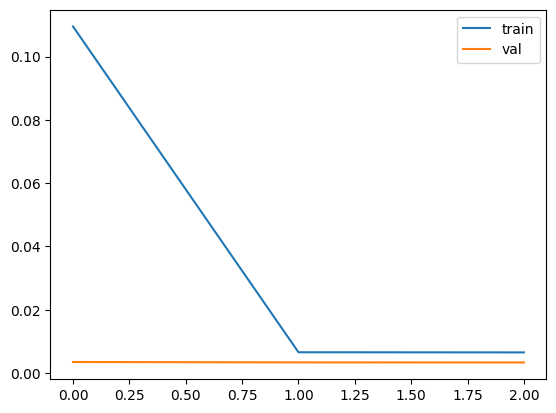

In [282]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

In [283]:
M = torch.zeros((data_description['n_ratings'], data_description['n_ratings']), device=ae.L.weight.device)
for i in range(data_description['n_ratings']):
    d = torch.ones(data_description['n_ratings']-i, device=ae.L.weight.device) * ae.L.weight[i]
    M = M + torch.diag(d, diagonal=-i)
M

tensor([[-0.7077,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6534, -0.7077,  0.0000,  0.0000,  0.0000],
        [-0.4972,  0.6534, -0.7077,  0.0000,  0.0000],
        [-0.3763, -0.4972,  0.6534, -0.7077,  0.0000],
        [-0.5481, -0.3763, -0.4972,  0.6534, -0.7077]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [284]:
M @ M.T

tensor([[ 0.5008, -0.4624,  0.3519,  0.2663,  0.3879],
        [-0.4624,  0.9277, -0.7873,  0.1060, -0.0918],
        [ 0.3519, -0.7873,  1.1750, -0.6002,  0.3785],
        [ 0.2663,  0.1060, -0.6002,  1.3166, -0.3939],
        [ 0.3879, -0.0918,  0.3785, -0.3939,  1.6170]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [285]:
# Testing the AE
test_loss = 0
# model = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
# model.load_state_dict(torch.load('best-model.pt'))

scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False
    scores[i] = output[0].T

    loss = criterion(output, target)
    test_loss += loss.data.item()

scores = scores.detach().numpy()    
print('test loss: '+str(test_loss / testset.userid.nunique()))

C:\Users\Liza\AppData\Local\Temp\ipykernel_9448\3144881825.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  scores[i] = output[0].T


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.00 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [40]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0092, MRR@5 = 0.0058, Coverage@5 = 0.0203
HR_pos@5 = 0.0081, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0054, MRR_neg@5 = 0.0004
Matthews@5 = 0.0137
-------------------------------------
HR@10 = 0.0190, MRR@10 = 0.0070, Coverage@10 = 0.0317
HR_pos@10 = 0.0178, HR_neg@10 = 0.0012
MRR_pos@10 = 0.0066, MRR_neg@10 = 0.0004
Matthews@10 = 0.0431
-------------------------------------
HR@20 = 0.0409, MRR@20 = 0.0085, Coverage@20 = 0.0529
HR_pos@20 = 0.0380, HR_neg@20 = 0.0029
MRR_pos@20 = 0.0080, MRR_neg@20 = 0.0005
Matthews@20 = 0.0587
-------------------------------------


(0.007043536632144227, 0.0189873417721519, 0.04310505000932261)

### Tuning

In [14]:
grid1 = 2**np.arange(9, 11) #2**np.arange(4, 11)
grid2 = np.arange(3, 5)
grid = np.meshgrid(grid2, grid1)

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []
early_stop = 10
n_epochs = 1000


for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=14):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    mask = torch.triu(torch.ones_like(ae.L.weight)).T
#     Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []
#     prev_train_loss = []
    prev_test_loss = [1000]
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1
    
    for epoch in range(n_epochs):
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / len(train_dataloader))

        test_loss = 0
        with torch.no_grad():
            for user in testset_valid.userid.unique():
                itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
                feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
                values = np.ones(len(itemidx), dtype=np.float32)

                user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
                target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

                output = ae(user_tensor_test)
                target.require_grad = False

                loss = criterion(output, target)
                test_loss += loss.data.item()
        val_loss = test_loss / testset.userid.nunique()
        val_history.append(val_loss)

        if prev_test_loss[-1] > val_loss:
            prev_test_loss = [val_loss]
            torch.save(bae.state_dict(), f'best_ae_{h}.pt')
        else:
            prev_test_loss.append(val_loss)
        
        stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_test_loss) == early_stop:
            print(f'Current epoch {epoch}. Best model found at epoch {stop}')
            break
            
        epoch += 1
    
    # Testing the AE
    test_loss = 0
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    model = AE(data_description['n_items'], h).to(device)
    model.load_state_dict(torch.load(f'best_ae_{h}.pt'))

    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        scores[i] = output[0].T
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())        
    scores = scores.detach().numpy()
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    print('Epochs:', stop)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

## Model: square root matrix

In [19]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [20]:
len(train_dataloader)

823

In [21]:
data_description['n_items'], data_description['n_ratings']

(9906, 5)

In [12]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            s, V = torch.linalg.eig(m.weight)
            m.weight.copy_(V @ torch.diag(torch.sqrt(s)) @ torch.linalg.inv(V))
            
# def get_zero_grad_hook(mask):
#     def hook(grad):
#         return grad * mask
#     return hook

In [13]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
        torch.nn.init.eye_(self.L.weight)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
#         x = self.norm(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = self.relu(output)
        output = torch.matmul(output, self.L.weight)
#         output = self.norm(output)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.matmul(outputT, self.V.weight)
        output = torch.transpose(outputT, -1, -2)
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [15]:
fix_torch_seed(42)
set_random_seed(42)

ae = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

C:\Users\Liza\AppData\Local\Temp\ipykernel_21496\1739130729.py:5: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  m.weight.copy_(V @ torch.diag(torch.sqrt(s)) @ torch.linalg.inv(V))


In [18]:
ae.L.weight @ ae.L.weight

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], device='cuda:0', grad_fn=<MmBackward0>)

In [24]:
# mask = torch.triu(torch.ones_like(ae.L.weight)).T
# # Register with hook
# ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [19]:
sum(p.numel() for p in ae.parameters() if p.requires_grad)

2536251

Epoch 20


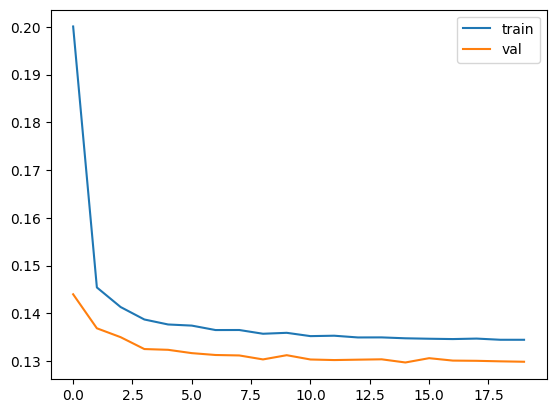

In [35]:
# Training the AE
history = []
val_history = []

prev_train_loss = 1
prev_test_loss = 1
train_loss = 0.1 * len(train_dataloader)
test_loss = 0.1 * testset_valid.userid.nunique()
epoch = 1
best_valid_loss = float('inf')

while prev_test_loss - test_loss / testset_valid.userid.nunique() > 1e-4 or test_loss / testset_valid.userid.nunique() > 0.13:
    if epoch > 1:
        prev_train_loss = train_loss / len(train_dataloader)
        prev_test_loss = test_loss / testset_valid.userid.nunique()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, user_matrix = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = user_matrix.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
    
    scheduler.step()
    history.append(train_loss / len(train_dataloader))
    
    test_loss = 0
    with torch.no_grad():
        for user in testset_valid.userid.unique():
            itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
            feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
            values = np.ones(len(itemidx), dtype=np.float32)

            user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
            target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

            output = ae(user_tensor_test)
            target.require_grad = False

            loss = criterion(output, target)
            test_loss += loss.data.item()
    
    valid_loss = test_loss / testset_valid.userid.nunique()
    val_history.append(valid_loss)
#         print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ae.state_dict(), 'best-model.pt')
    
    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    epoch += 1
#     print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

In [18]:
ae.L.weight

Parameter containing:
tensor([[-0.1739,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0287,  0.6074,  0.0000,  0.0000,  0.0000],
        [ 0.0600, -0.1837, -0.5307,  0.0000,  0.0000],
        [ 0.4533,  0.2487, -0.4121,  0.0950,  0.0000],
        [-0.6271,  0.1836, -0.7649,  0.3127, -0.5906]], device='cuda:0',
       requires_grad=True)

In [21]:
ae.L.weight @ ae.L.weight.T

tensor([[ 0.0302,  0.0050, -0.0104, -0.0788,  0.1091],
        [ 0.0050,  0.3697, -0.1133,  0.1380,  0.1295],
        [-0.0104, -0.1133,  0.3189,  0.2002,  0.3345],
        [-0.0788,  0.1380,  0.2002,  0.4462,  0.1064],
        [ 0.1091,  0.1295,  0.3345,  0.1064,  1.4587]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [38]:
# Testing the AE
test_loss = 0
# model = AE(data_description['n_items'], data_description['n_ratings'], 256, 3).to(device)
# model.load_state_dict(torch.load('best-model.pt'))

scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)
    
    output = ae(user_tensor_test)
    target.require_grad = False
    scores[i] = output[0].T

    loss = criterion(output, target)
    test_loss += loss.data.item()

scores = scores.detach().numpy()    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.12897759667405873


In [40]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0092, MRR@5 = 0.0058, Coverage@5 = 0.0203
HR_pos@5 = 0.0081, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0054, MRR_neg@5 = 0.0004
Matthews@5 = 0.0137
-------------------------------------
HR@10 = 0.0190, MRR@10 = 0.0070, Coverage@10 = 0.0317
HR_pos@10 = 0.0178, HR_neg@10 = 0.0012
MRR_pos@10 = 0.0066, MRR_neg@10 = 0.0004
Matthews@10 = 0.0431
-------------------------------------
HR@20 = 0.0409, MRR@20 = 0.0085, Coverage@20 = 0.0529
HR_pos@20 = 0.0380, HR_neg@20 = 0.0029
MRR_pos@20 = 0.0080, MRR_neg@20 = 0.0005
Matthews@20 = 0.0587
-------------------------------------


(0.007043536632144227, 0.0189873417721519, 0.04310505000932261)

### Tuning

In [14]:
grid1 = 2**np.arange(9, 11) #2**np.arange(4, 11)
grid2 = np.arange(3, 5)
grid = np.meshgrid(grid2, grid1)

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []
early_stop = 10
n_epochs = 1000


for h1, h2, in tqdm(zip(grid[1].flatten(), grid[0].flatten()), total=14):
    print('Hidden sizes:', h1, h2)
    
    ae = AE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    mask = torch.triu(torch.ones_like(ae.L.weight)).T
#     Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []
#     prev_train_loss = []
    prev_test_loss = [1000]
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1
    
    for epoch in range(n_epochs):
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / len(train_dataloader))

        test_loss = 0
        with torch.no_grad():
            for user in testset_valid.userid.unique():
                itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
                feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
                values = np.ones(len(itemidx), dtype=np.float32)

                user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
                target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                          size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

                output = ae(user_tensor_test)
                target.require_grad = False

                loss = criterion(output, target)
                test_loss += loss.data.item()
        val_loss = test_loss / testset.userid.nunique()
        val_history.append(val_loss)

        if prev_test_loss[-1] > val_loss:
            prev_test_loss = [val_loss]
            torch.save(bae.state_dict(), f'best_ae_{h}.pt')
        else:
            prev_test_loss.append(val_loss)
        
        stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_test_loss) == early_stop:
            print(f'Current epoch {epoch}. Best model found at epoch {stop}')
            break
            
        epoch += 1
    
    # Testing the AE
    test_loss = 0
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    model = AE(data_description['n_items'], h).to(device)
    model.load_state_dict(torch.load(f'best_ae_{h}.pt'))

    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        scores[i] = output[0].T
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())        
    scores = scores.detach().numpy()
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    print('Epochs:', stop)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

## Model: output -- tensor

In [ ]:
class TensorDataset(Dataset):
    def __init__(self, data, data_description):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        return self.tensor[idx], self.tensor[idx]

In [16]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [24]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2, hid3):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        self.W = nn.Linear(hid3, hid2)
        self.L = nn.Linear(n_ratings, hid3)
        triu_init(self.L)
#         self.vec = nn.Linear(n_ratings, 1)
#         self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.W(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = torch.matmul(output, self.L.weight)
        output = torch.transpose(torch.matmul(torch.transpose(output, -1, -2), self.V.weight), -1, -2)
        # vec
#         output = self.tanh(output)
#         output = self.vec(output).squeeze(-1)
        return output

ae = AE(data_description['n_items'], data_description['n_ratings'], 100, 50, 20).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())

In [25]:
mask = torch.triu(torch.ones_like(ae.L.weight))
# Register with hook
ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [26]:
# Training the AE
n_epochs = 100
history = []

for epoch in range(1, n_epochs + 1):   
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, true_user_tensor = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = true_user_tensor.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    history.append(train_loss / len(train_dataloader))
        
    print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

epoch: 1 loss: 0.05756956117039316
epoch: 2 loss: 0.03614815729862072
epoch: 3 loss: 0.03575290020987782
epoch: 4 loss: 0.03627321601946479
epoch: 5 loss: 0.03485188916437188
epoch: 6 loss: 0.034166774960158026
epoch: 7 loss: 0.03377212845626172
epoch: 8 loss: 0.03298012822978059
epoch: 9 loss: 0.03216922597101565
epoch: 10 loss: 0.031279375748743725
epoch: 11 loss: 0.030928388192607893
epoch: 12 loss: 0.030600117746224342
epoch: 13 loss: 0.030427866992069764
epoch: 14 loss: 0.02986297190663743
epoch: 15 loss: 0.029729154745765617
epoch: 16 loss: 0.029318355819147626
epoch: 17 loss: 0.02909153669179602
epoch: 18 loss: 0.02883792771479945
epoch: 19 loss: 0.028575731075128143
epoch: 20 loss: 0.02832073374382789
epoch: 21 loss: 0.02810518795184875
epoch: 22 loss: 0.027664527045876793
epoch: 23 loss: 0.02710385677798857
epoch: 24 loss: 0.02677095800024293
epoch: 25 loss: 0.025914379716449686
epoch: 26 loss: 0.025117510825060727
epoch: 27 loss: 0.024279714157379298
epoch: 28 loss: 0.0233689

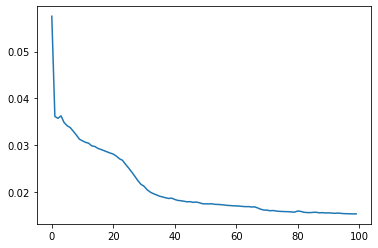

In [27]:
plt.plot(history)

In [30]:
# Testing the AE
test_loss = 0

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = user_tensor_test.clone()
    
    output = ae(user_tensor_test)
    target.require_grad = False

    loss = criterion(output, target)
    test_loss += loss.data.item()
    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.02183415055544881


In [51]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)
    
    output = ae(user_matrix_test)
    scores[i] = output[0][:, -1].T

        
scores = scores.detach().numpy()

In [52]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0207, MRR@5 = 0.0097, Coverage@5 = 0.2287
HR_pos@5 = 0.0196, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0089, MRR_neg@5 = 0.0007
Matthews@5 = 0.0455
-------------------------------------
HR@10 = 0.0288, MRR@10 = 0.0107, Coverage@10 = 0.2981
HR_pos@10 = 0.0265, HR_neg@10 = 0.0023
MRR_pos@10 = 0.0098, MRR_neg@10 = 0.0009
Matthews@10 = 0.0427
-------------------------------------
HR@20 = 0.0454, MRR@20 = 0.0119, Coverage@20 = 0.4004
HR_pos@20 = 0.0431, HR_neg@20 = 0.0023
MRR_pos@20 = 0.0110, MRR_neg@20 = 0.0009
Matthews@20 = 0.0711
-------------------------------------


(0.010699453252644743, 0.02875215641173088, 0.042746208372664046)